# 5. ImageSegmentationPipeline与目标分割任务应用

## 5.1. 目标分割任务概述

- 图像分割是将图像划分为多个区域的任务，其中图像中的每个像素都被映射到特定的对象。该任务包含多种变体，例如实例分割、全景分割和语义分割。
    - **语义分割**：语义分割是图像分割中最基础的概念。它的目标是将图像中的每个像素都赋予一个类别标签（如人、车、树、天空、道路等）。
    - **实例分割**：实例分割可以看作是目标检测 + 语义分割的结合体。它不仅要对像素进行分类，还要区分出同一类别的不同个体。
    - **全景分割**：全景分割是近年来比较高级和统一的图像分割任务。它相当于语义分割 + 实例分割的融合。不像实例分割只处理物体，全景分割连背景（如天空、草地）也要分割干净。

- 目标分割任务实现的算法模型结构：
    - 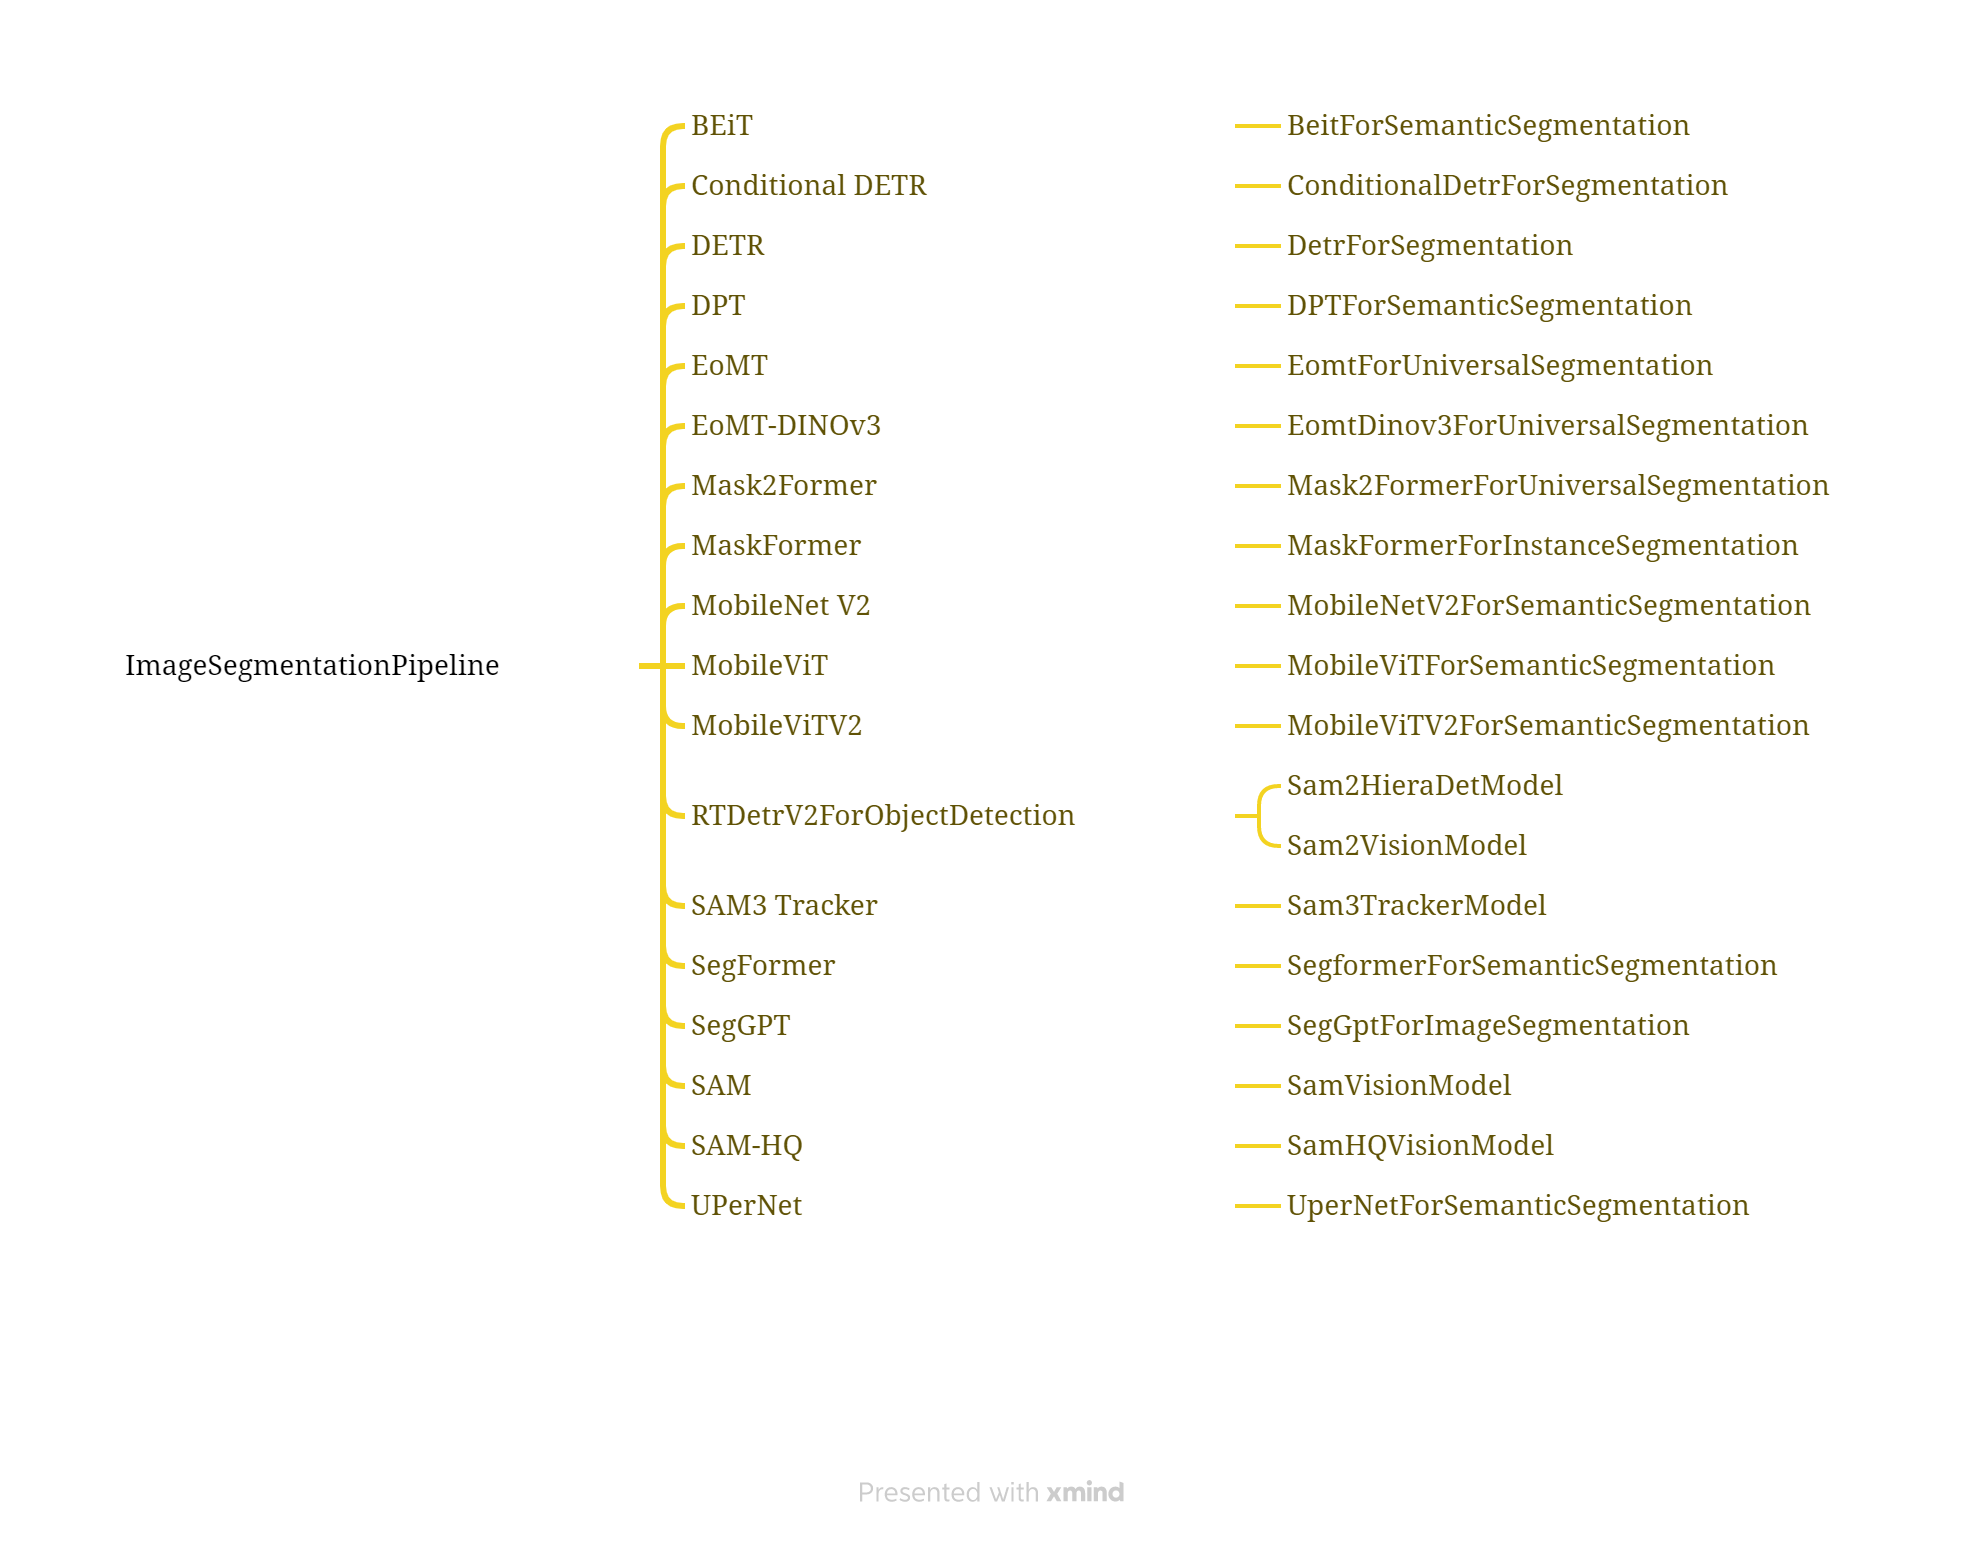

- 下面是我们需要介绍的分类分割模型：
    - 语义分割：
        - SegFormer
        - DPT (虽主要用于深度估计，但其架构也被用于语义分割)
    - 实例分割：
        - MaskFormer
    - 全景分割：
        - DETR (及其变体）
    - 通用模型：
        - Mask2Former

## 5.2. 语义分割模型应用-segformer与dpt算法 

- SegFormer 包含一个分层的 Transformer 编码器和一个轻量级全 MLP 解码头，以在诸如 ADE20K 和 Cityscapes 等语义分割基准测试中取得优异结果。首先在 ImageNet-1k 上预训练分层 Transformer，之后添加解码头并在下游数据集上一起微调。
- 您可以使用原始模型进行语义分割。

### (1) 模型下载

- 我们下载SegFormer算法模型。
    - `git clone https://www.modelscope.cn/nv-community/segformer-b4-finetuned-ade-512-512.git`
    - `git clone https://www.modelscope.cn/1038lab/segformer_fashion.git`

### (2) 模型应用

- 使用pipeline函数构造的ImageSegmentationPipeline对象进行推理。

Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.
C:\Program Files\Python313\Lib\site-packages\transformers\image_processing_base.py:417: UserWarning: The following named arguments are not valid for `SegformerImageProcessor.__init__` and were ignored: 'reduce_labels'
  image_processor = cls(**image_processor_dict)
Device set to use cuda:0


分隔目标数量： 6
每个分隔目标的数据字段： dict_keys(['score', 'label', 'mask'])
{'score': None, 'label': 'building', 'mask': <PIL.Image.Image image mode=L size=1706x1279 at 0x2737D3CC8D0>}


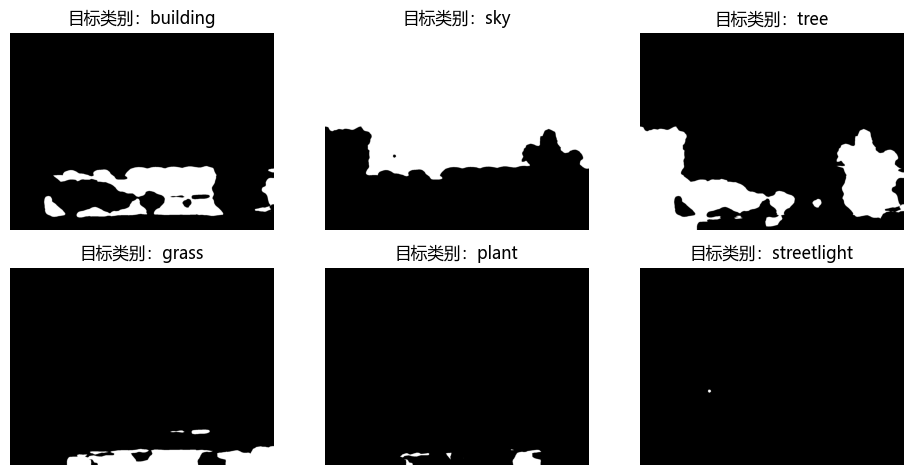

In [1]:
from transformers import pipeline
import matplotlib.pyplot as plt
plt.rcParams["font.family"] = ["Microsoft YaHei"]

img_file = "./imgs/scene.jpg"

pipe = pipeline("image-segmentation", model="F:/03Models/segformer-b4-finetuned-ade-512-512")

outputs = pipe(img_file)
print("分隔目标数量：", len(outputs))
print("每个分隔目标的数据字段：", outputs[0].keys())
print(outputs[0])
count = len(outputs)
cols = 3
rows = count // cols + 1
plt.figure(figsize=(3.2 * cols, 2.4 * rows))
for i in range(count):
    plt.subplot(rows, cols, i+1)
    plt.imshow(outputs[i]["mask"], cmap="gray")
    plt.title(F"目标类别：{outputs[i]['label']}")
    plt.axis(False)
plt.tight_layout()
plt.show()

- 代码说明：
    - 输出数据是一个列表，每个元素表示分割目标，每个分隔目标是有三个字段："score","label","mask"。
    - 每个分隔目标使用PIL.Image表示，可以转换为ndarray使用。
    - 我们在代码中直接输出每个分隔目标，没有融合渲染在一张图像上面。（下面处理并掌握分割目标的mask处理方法。）
    - 因为是像素层面的语义分割，所以输出的score中没有分类概率（得分）。
    - 上面还可以使用preprocess，forward，postprocess来分段处理。

### (3) 模型分析

- 直接使用模型，分别进行预处理，推理，后处理三个步骤，并使用mask来在图像上直接表示分割目标。

图像大小： (1706, 1279)
推理输出的logits维度： torch.Size([1, 150, 320, 427])
SemanticSegmenterOutput(loss=None, logits=tensor([[[[-12.8989, -13.2284, -13.3056,  ..., -13.7704, -10.9039,  -8.1372],
          [-13.8038, -15.0809, -15.1347,  ..., -14.5206, -10.9606,  -7.8209],
          [-13.8536, -15.0708, -15.3606,  ..., -13.9468, -10.4384,  -7.6748],
          ...,
          [-10.3517, -11.2183, -11.1834,  ...,  -8.3125,  -6.6511,  -4.1285],
          [-10.4691, -10.9073, -10.7282,  ...,  -7.0827,  -6.3407,  -4.1853],
          [ -7.1885,  -7.3121,  -7.2391,  ...,  -4.6543,  -4.4593,  -4.2746]],

         [[-12.5479, -12.9343, -13.0688,  ...,  -9.1417,  -6.1859,  -3.8388],
          [-13.5372, -14.7869, -14.9882,  ...,  -9.8287,  -6.2779,  -3.5416],
          [-13.5024, -14.7508, -15.2524,  ...,  -9.0911,  -5.4532,  -3.3243],
          ...,
          [ -8.8441,  -9.9788, -10.0931,  ...,  -9.0216,  -6.8123,  -3.7339],
          [ -8.5814,  -9.2608,  -9.2763,  ...,  -7.5064,  -6.1674,  -3.7342],
   

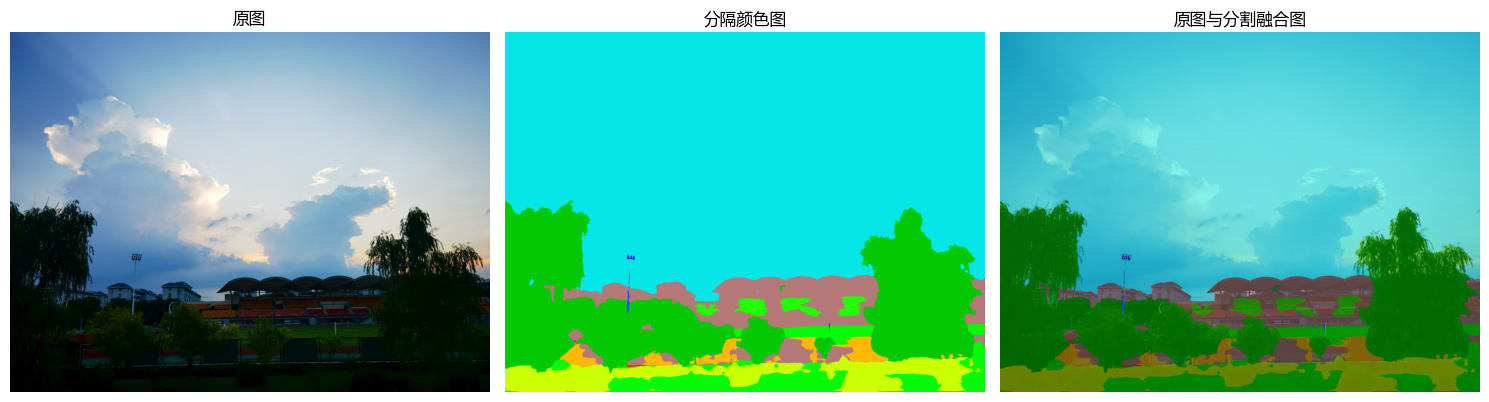

In [2]:
from transformers import SegformerImageProcessor, SegformerForSemanticSegmentation
import torch
import PIL
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams["font.family"] = ["Microsoft YaHei"]

# 根据硬件情况，选择是否使用GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# 1. 模型加载
model_name = "F:/03Models/segformer-b4-finetuned-ade-512-512"
model = SegformerForSemanticSegmentation.from_pretrained(model_name)
# 使用GPU
model.to(device)

# 2. 图像处理器构造（我们没有加载，而是直接构造）
processor = SegformerImageProcessor(do_resize=False)  # 我们没有采用模型配置，而是直接构造，并且不进行缩放
# 处理图像，并把数据加载到GPU
image = "./imgs/scene.jpg"
image = PIL.Image.open(img_file)   # 打开图像
image = PIL.ImageOps.exif_transpose(image)  
image = image.convert("RGB")  # 一般jpg默认是RGB，png可能是RGBA
print("图像大小：", image.size)
pixel_values = processor([image], return_tensors="pt").pixel_values.to(device)

# 3. 模型推理
with torch.no_grad():
    outputs = model(pixel_values)
    print("推理输出的logits维度：", outputs.logits.shape)
    print(outputs)
# 4. 后处理
segmentation_map = processor.post_process_semantic_segmentation(outputs, target_sizes=[image.size[::-1]])
# 转换为ndarray
segmentation_map = segmentation_map[0].cpu().numpy()
print("后处理维度：", segmentation_map.shape)
print(segmentation_map)

# 5. 可视化
palette = np.array(
    [[120, 120, 120], [180, 120, 120], [6, 230, 230], [80, 50, 50],
    [4, 200, 3], [120, 120, 80], [140, 140, 140], [204, 5, 255],
    [230, 230, 230], [4, 250, 7], [224, 5, 255], [235, 255, 7],
    [150, 5, 61], [120, 120, 70], [8, 255, 51], [255, 6, 82],
    [143, 255, 140], [204, 255, 4], [255, 51, 7], [204, 70, 3],
    [0, 102, 200], [61, 230, 250], [255, 6, 51], [11, 102, 255],
    [255, 7, 71], [255, 9, 224], [9, 7, 230], [220, 220, 220],
    [255, 9, 92], [112, 9, 255], [8, 255, 214], [7, 255, 224],
    [255, 184, 6], [10, 255, 71], [255, 41, 10], [7, 255, 255],
    [224, 255, 8], [102, 8, 255], [255, 61, 6], [255, 194, 7],
    [255, 122, 8], [0, 255, 20], [255, 8, 41], [255, 5, 153],
    [6, 51, 255], [235, 12, 255], [160, 150, 20], [0, 163, 255],
    [140, 140, 140], [250, 10, 15], [20, 255, 0], [31, 255, 0],
    [255, 31, 0], [255, 224, 0], [153, 255, 0], [0, 0, 255],
    [255, 71, 0], [0, 235, 255], [0, 173, 255], [31, 0, 255],
    [11, 200, 200], [255, 82, 0], [0, 255, 245], [0, 61, 255],
    [0, 255, 112], [0, 255, 133], [255, 0, 0], [255, 163, 0],
    [255, 102, 0], [194, 255, 0], [0, 143, 255], [51, 255, 0],
    [0, 82, 255], [0, 255, 41], [0, 255, 173], [10, 0, 255],
    [173, 255, 0], [0, 255, 153], [255, 92, 0], [255, 0, 255],
    [255, 0, 245], [255, 0, 102], [255, 173, 0], [255, 0, 20],
    [255, 184, 184], [0, 31, 255], [0, 255, 61], [0, 71, 255],
    [255, 0, 204], [0, 255, 194], [0, 255, 82], [0, 10, 255],
    [0, 112, 255], [51, 0, 255], [0, 194, 255], [0, 122, 255],
    [0, 255, 163], [255, 153, 0], [0, 255, 10], [255, 112, 0],
    [143, 255, 0], [82, 0, 255], [163, 255, 0], [255, 235, 0],
    [8, 184, 170], [133, 0, 255], [0, 255, 92], [184, 0, 255],
    [255, 0, 31], [0, 184, 255], [0, 214, 255], [255, 0, 112],
    [92, 255, 0], [0, 224, 255], [112, 224, 255], [70, 184, 160],
    [163, 0, 255], [153, 0, 255], [71, 255, 0], [255, 0, 163],
    [255, 204, 0], [255, 0, 143], [0, 255, 235], [133, 255, 0],
    [255, 0, 235], [245, 0, 255], [255, 0, 122], [255, 245, 0],
    [10, 190, 212], [214, 255, 0], [0, 204, 255], [20, 0, 255],
    [255, 255, 0], [0, 153, 255], [0, 41, 255], [0, 255, 204],
    [41, 0, 255], [41, 255, 0], [173, 0, 255], [0, 245, 255],
    [71, 0, 255], [122, 0, 255], [0, 255, 184], [0, 92, 255],
    [184, 255, 0], [0, 133, 255], [255, 214, 0], [25, 194, 194],
    [102, 255, 0], [92, 0, 255]])  # 150个类别，每个类别定义一个颜色，这来自ADE20K数据集的定义。
print(palette.shape)

# 定义一个图像，用来把mask按照palette的颜色模版转换为像素图。
color_seg = np.zeros(
    (segmentation_map.shape[0],segmentation_map.shape[1], 3), 
    dtype=np.uint8
)
# 循环把每个颜色，批量替换为像素
for label, color in enumerate(palette):  # label表示颜色索引
    color_seg[segmentation_map == label, :] = color

print("分隔目标颜色图大小：", color_seg.shape)

# 融合原图
img = np.array(image) * 0.5 + color_seg * 0.5
img = img.astype(np.uint8)  # 转换为像素格式

plt.figure(figsize=(15, 10))

plt.subplot(131)
plt.imshow(image)
plt.title("原图")
plt.axis(False)

plt.subplot(132)
plt.imshow(color_seg)
plt.title("分隔颜色图")
plt.axis(False)

plt.subplot(133)
plt.imshow(img)
plt.title("原图与分割融合图")
plt.axis(False)

plt.tight_layout()
plt.show()

- 代码说明：
    - 推理输出的logits维度格式为：(batch_size, num_labels, height/4, width/4)
    - 后处理是把多个目标合并在一个mask中。mask大小与图像一样大小。（注意：在PIL中图像大小表示格式`[宽度，高度]`，但是在torch, numpy中图像大小表示格式`[高度，宽度]`）

- 下面是直接调用模型的处理方式（没有使用图像处理器）
    - 使用的是intel的dpt算法模型

Some weights of DPTForSemanticSegmentation were not initialized from the model checkpoint at F:/03Models/dpt-large-ade and are newly initialized: ['neck.fusion_stage.layers.0.residual_layer1.batch_norm1.bias', 'neck.fusion_stage.layers.0.residual_layer1.batch_norm1.num_batches_tracked', 'neck.fusion_stage.layers.0.residual_layer1.batch_norm1.running_mean', 'neck.fusion_stage.layers.0.residual_layer1.batch_norm1.running_var', 'neck.fusion_stage.layers.0.residual_layer1.batch_norm1.weight', 'neck.fusion_stage.layers.0.residual_layer1.batch_norm2.bias', 'neck.fusion_stage.layers.0.residual_layer1.batch_norm2.num_batches_tracked', 'neck.fusion_stage.layers.0.residual_layer1.batch_norm2.running_mean', 'neck.fusion_stage.layers.0.residual_layer1.batch_norm2.running_var', 'neck.fusion_stage.layers.0.residual_layer1.batch_norm2.weight', 'neck.fusion_stage.layers.0.residual_layer1.convolution1.weight', 'neck.fusion_stage.layers.0.residual_layer1.convolution2.weight']
You should probably TRAIN t

450


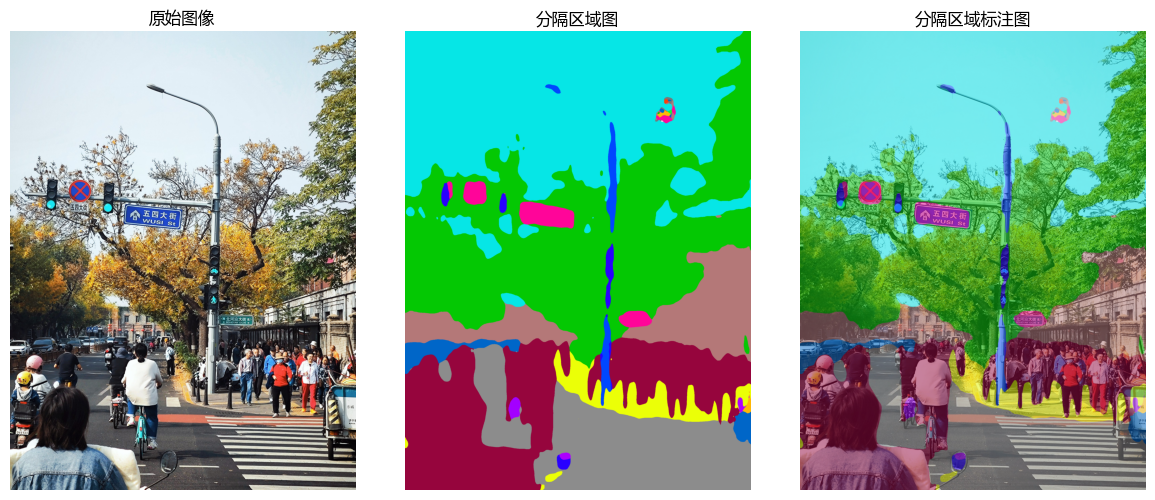

In [3]:
from transformers import DPTForSemanticSegmentation
import torch
import PIL
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams["font.family"] = ["Microsoft YaHei"]

# 加载模型
model = DPTForSemanticSegmentation.from_pretrained("F:/03Models/dpt-large-ade")

# 分隔图像文件
img_file = "./imgs/street.jpg"
image = Image.open(img_file)

# 对图像进行预处理
from torchvision.transforms import Compose, Resize, ToTensor, Normalize
h = w = 480

transform = Compose([
        Resize((h, w)),
        ToTensor(),
        Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5]),
    ])

pixel_values = transform(image).unsqueeze(0)
# 分隔推理
import torch

with torch.no_grad():
    outputs = model(pixel_values)
    logits = outputs.logits

# 把推理缩放与原图像一致
prediction = torch.nn.functional.interpolate(
    logits, 
    size=image.size[::-1], 
    mode="bicubic", 
    align_corners=False
)

# 把分割区域进行分类。
prediction = torch.argmax(prediction, dim=1)
prediction = prediction.squeeze().cpu().numpy()
predicted_seg = Image.fromarray(prediction.squeeze().astype('uint8'))
# 因为模型是在ADE20K数据集上训练的，下面是ADE20K的颜色模版（3个一组颜色）
adepallete = [120,120,120,180,120,120,6,230,230,80,50,50,4,200,3,120,120,80,140,140,140,204,5,255,230,230,230,4,250,7,224,5,255,235,255,7,150,5,61,120,120,70,8,255,51,255,6,82,143,255,140,204,255,4,255,51,7,204,70,3,0,102,200,61,230,250,255,6,51,11,102,255,255,7,71,255,9,224,9,7,230,220,220,220,255,9,92,112,9,255,8,255,214,7,255,224,255,184,6,10,255,71,255,41,10,7,255,255,224,255,8,102,8,255,255,61,6,255,194,7,255,122,8,0,255,20,255,8,41,255,5,153,6,51,255,235,12,255,160,150,20,0,163,255,140,140,140,250,10,15,20,255,0,31,255,0,255,31,0,255,224,0,153,255,0,0,0,255,255,71,0,0,235,255,0,173,255,31,0,255,11,200,200,255,82,0,0,255,245,0,61,255,0,255,112,0,255,133,255,0,0,255,163,0,255,102,0,194,255,0,0,143,255,51,255,0,0,82,255,0,255,41,0,255,173,10,0,255,173,255,0,0,255,153,255,92,0,255,0,255,255,0,245,255,0,102,255,173,0,255,0,20,255,184,184,0,31,255,0,255,61,0,71,255,255,0,204,0,255,194,0,255,82,0,10,255,0,112,255,51,0,255,0,194,255,0,122,255,0,255,163,255,153,0,0,255,10,255,112,0,143,255,0,82,0,255,163,255,0,255,235,0,8,184,170,133,0,255,0,255,92,184,0,255,255,0,31,0,184,255,0,214,255,255,0,112,92,255,0,0,224,255,112,224,255,70,184,160,163,0,255,153,0,255,71,255,0,255,0,163,255,204,0,255,0,143,0,255,235,133,255,0,255,0,235,245,0,255,255,0,122,255,245,0,10,190,212,214,255,0,0,204,255,20,0,255,255,255,0,0,153,255,0,41,255,0,255,204,41,0,255,41,255,0,173,0,255,0,245,255,71,0,255,122,0,255,0,255,184,0,92,255,184,255,0,0,133,255,255,214,0,25,194,194,102,255,0,92,0,255]
print(len(adepallete))   # 150个类别，一共450个元素
# 把分类按照模版映射为颜色，得到一个分割区域图像。
predicted_seg.putpalette(adepallete)

# 把原图像与区域分割图像混合一起（区域图像使用一定透明度）
out = Image.blend(image, predicted_seg.convert("RGB"), alpha=0.5)

plt.figure(figsize=(12, 5))
# 显示原始图像
plt.subplot(131)
plt.imshow(image)
plt.title("原始图像")
plt.axis('off')

# 显示深度灰度图（值越接近1（亮）表示越近）
plt.subplot(132)
plt.imshow(predicted_seg)
plt.title("分隔区域图")
plt.axis('off')

# 显示深度彩色热力图
plt.subplot(133)
plt.imshow(out)
plt.title("分隔区域标注图")
plt.axis('off')

plt.tight_layout()
plt.show()

- 代码说明：
    - 代码中使用的模型已经在深度估计中下载，DPT算法可以完成**深度估计**与**目标分割**两种类型的推理功能。
    - 在这段代码中，没有使用图像处理器，而是手工实现了图像处理器的前处理与后处理（我们在其中还对图像进行了resize，nornalize处理）。

```python
transform = Compose([
        Resize((h, w)),
        ToTensor(),
        Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5]),
    ]
)
```

## 5.3. 实例分隔模型应用-maskformer与mask2former算法

### (1) 模型下载

- 下载MaskFormer模型
    - `git clone https://www.modelscope.cn/facebook/maskformer-swin-large-coco.git`
    - `git clone https://www.modelscope.cn/facebook/mask2former-swin-large-coco-instance.git`

### (2) 模型应用

- pipeline调用例子

C:\Program Files\Python313\Lib\site-packages\transformers\image_processing_base.py:417: UserWarning: The following named arguments are not valid for `MaskFormerImageProcessor.__init__` and were ignored: 'size_divisibility'
  image_processor = cls(**image_processor_dict)
Device set to use cuda:0
`label_ids_to_fuse` unset. No instance will be fused.


dict_keys(['score', 'label', 'mask'])
识别目标数量： 5


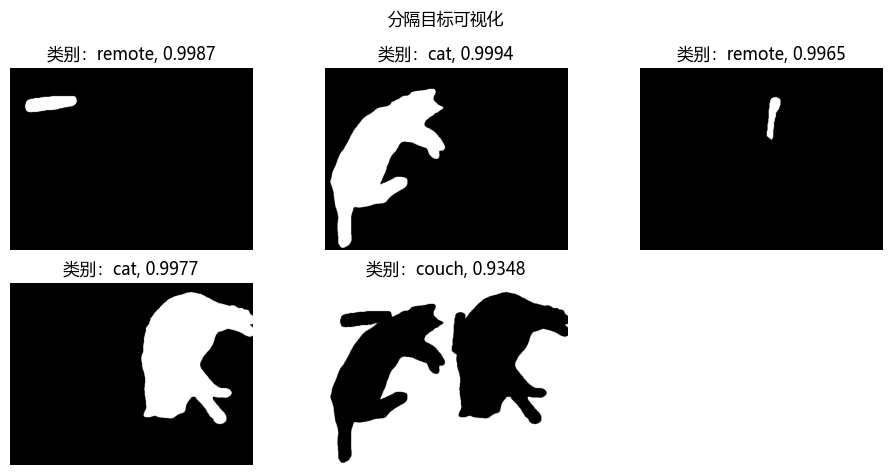

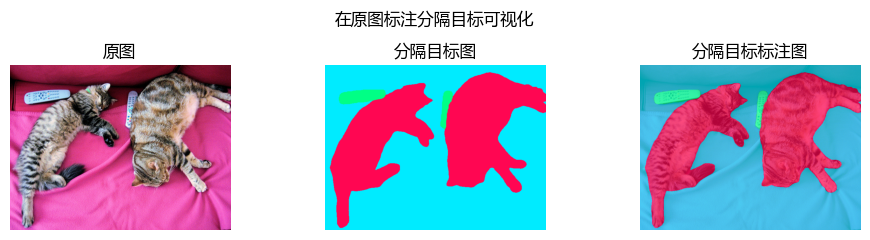

In [4]:
from transformers import pipeline
from PIL import Image
import matplotlib.pyplot as plt
plt.rcParams["font.family"] = ["Microsoft YaHei"]
# 直接推理
pipe = pipeline("image-segmentation", model="F:/03Models/maskformer-swin-large-coco")
image = Image.open("./imgs/000000039769.jpg")
results = pipe(image)
print(results[0].keys())
# print(results)


# 2. 可视化分隔的目标
count = len(results)
print("识别目标数量：", count)

cols = 3
rows = count // cols + 1

plt.figure(figsize=(3.2 * cols, 2.4 * rows))
plt.suptitle("分隔目标可视化")
for i in range(count):
    plt.subplot(rows, cols, i+1)
    plt.imshow(results[i]["mask"], cmap="gray")
    plt.title(F"类别：{results[i]['label']}, {results[i]['score']:06.4f}")
    plt.axis(False)
plt.tight_layout()
plt.show()

# 3. 在原图像中标注。
palette = np.array(
    [[120, 120, 120], [180, 120, 120], [6, 230, 230], [80, 50, 50],
    [4, 200, 3], [120, 120, 80], [140, 140, 140], [204, 5, 255],
    [230, 230, 230], [4, 250, 7], [224, 5, 255], [235, 255, 7],
    [150, 5, 61], [120, 120, 70], [8, 255, 51], [255, 6, 82],
    [143, 255, 140], [204, 255, 4], [255, 51, 7], [204, 70, 3],
    [0, 102, 200], [61, 230, 250], [255, 6, 51], [11, 102, 255],
    [255, 7, 71], [255, 9, 224], [9, 7, 230], [220, 220, 220],
    [255, 9, 92], [112, 9, 255], [8, 255, 214], [7, 255, 224],
    [255, 184, 6], [10, 255, 71], [255, 41, 10], [7, 255, 255],
    [224, 255, 8], [102, 8, 255], [255, 61, 6], [255, 194, 7],
    [255, 122, 8], [0, 255, 20], [255, 8, 41], [255, 5, 153],
    [6, 51, 255], [235, 12, 255], [160, 150, 20], [0, 163, 255],
    [140, 140, 140], [250, 10, 15], [20, 255, 0], [31, 255, 0],
    [255, 31, 0], [255, 224, 0], [153, 255, 0], [0, 0, 255],
    [255, 71, 0], [0, 235, 255], [0, 173, 255], [31, 0, 255],
    [11, 200, 200], [255, 82, 0], [0, 255, 245], [0, 61, 255],
    [0, 255, 112], [0, 255, 133], [255, 0, 0], [255, 163, 0],
    [255, 102, 0], [194, 255, 0], [0, 143, 255], [51, 255, 0],
    [0, 82, 255], [0, 255, 41], [0, 255, 173], [10, 0, 255],
    [173, 255, 0], [0, 255, 153], [255, 92, 0], [255, 0, 255],
    [255, 0, 245], [255, 0, 102], [255, 173, 0], [255, 0, 20],
    [255, 184, 184], [0, 31, 255], [0, 255, 61], [0, 71, 255],
    [255, 0, 204], [0, 255, 194], [0, 255, 82], [0, 10, 255],
    [0, 112, 255], [51, 0, 255], [0, 194, 255], [0, 122, 255],
    [0, 255, 163], [255, 153, 0], [0, 255, 10], [255, 112, 0],
    [143, 255, 0], [82, 0, 255], [163, 255, 0], [255, 235, 0],
    [8, 184, 170], [133, 0, 255], [0, 255, 92], [184, 0, 255],
    [255, 0, 31], [0, 184, 255], [0, 214, 255], [255, 0, 112],
    [92, 255, 0], [0, 224, 255], [112, 224, 255], [70, 184, 160],
    [163, 0, 255], [153, 0, 255], [71, 255, 0], [255, 0, 163],
    [255, 204, 0], [255, 0, 143], [0, 255, 235], [133, 255, 0],
    [255, 0, 235], [245, 0, 255], [255, 0, 122], [255, 245, 0],
    [10, 190, 212], [214, 255, 0], [0, 204, 255], [20, 0, 255],
    [255, 255, 0], [0, 153, 255], [0, 41, 255], [0, 255, 204],
    [41, 0, 255], [41, 255, 0], [173, 0, 255], [0, 245, 255],
    [71, 0, 255], [122, 0, 255], [0, 255, 184], [0, 92, 255],
    [184, 255, 0], [0, 133, 255], [255, 214, 0], [25, 194, 194],
    [102, 255, 0], [92, 0, 255]]
)
# palette = palette[:, :133]
img = np.array(image)

color_seg = np.zeros((img.shape[0], img.shape[1], 3), dtype=np.uint8) # height, width, 3

for obj in  results:
    score = obj["score"]
    label = obj["label"]
    mask =  obj["mask"]
    label_id = pipe.model.config.label2id[label]
    mask_numpy = np.array(mask)
    color_seg[mask_numpy == 255, :] = palette[label_id]

img_merge = img* 0.3 + color_seg * 0.7
img_merge = img_merge.astype(np.uint8)


plt.figure(figsize=(3.2 * cols, 2.4 * 1))
plt.suptitle("在原图标注分隔目标可视化")
plt.subplot(131)
plt.imshow(img)
plt.title("原图")
plt.axis(False)

plt.subplot(132)
plt.imshow(color_seg)
plt.title("分隔目标图")
plt.axis(False)

plt.subplot(133)
plt.imshow(img_merge)
plt.title("分隔目标标注图")
plt.axis(False)

plt.tight_layout()
plt.show()

- 代码说明：
    - 返回结果的每个侦测目标包含三个字段的数据：'score', 'label', 'mask'。
    - 因为是实例分割，所以score就是实例目标的识别概率。
    - 分隔的目标是使用PIL.Image表示，其中有目标的部分像素为255，其他地方是0。
    - 在config.json配置文件可以知道，目标类别一共133个类别，从0-132。
    - 在本例子中，我们说明了怎么把使用PIL.Image表示分割目标的mask合并成一个ndarray图像。

### (3) 模型调用分析

- 在前面仅仅是使用pipeline构建ImageSegmentationPipeline对象，并直接使用__call__调用推理（包含预处理，推理，后处理，典型的黑盒封装），在这个部分我们仅仅使用MaskFormerModel来完成推理任务，详细讲解预处理与后处理。其中推理模型的详细讲解，我们在训练主题来说明。
    - 我们同步使用MaskFormerImageProcessor类对比说明预处理与后处理的使用。
- 模型：`facebook/mask2former-swin-large-coco-instance`

- 相关类图结构如下：
    - 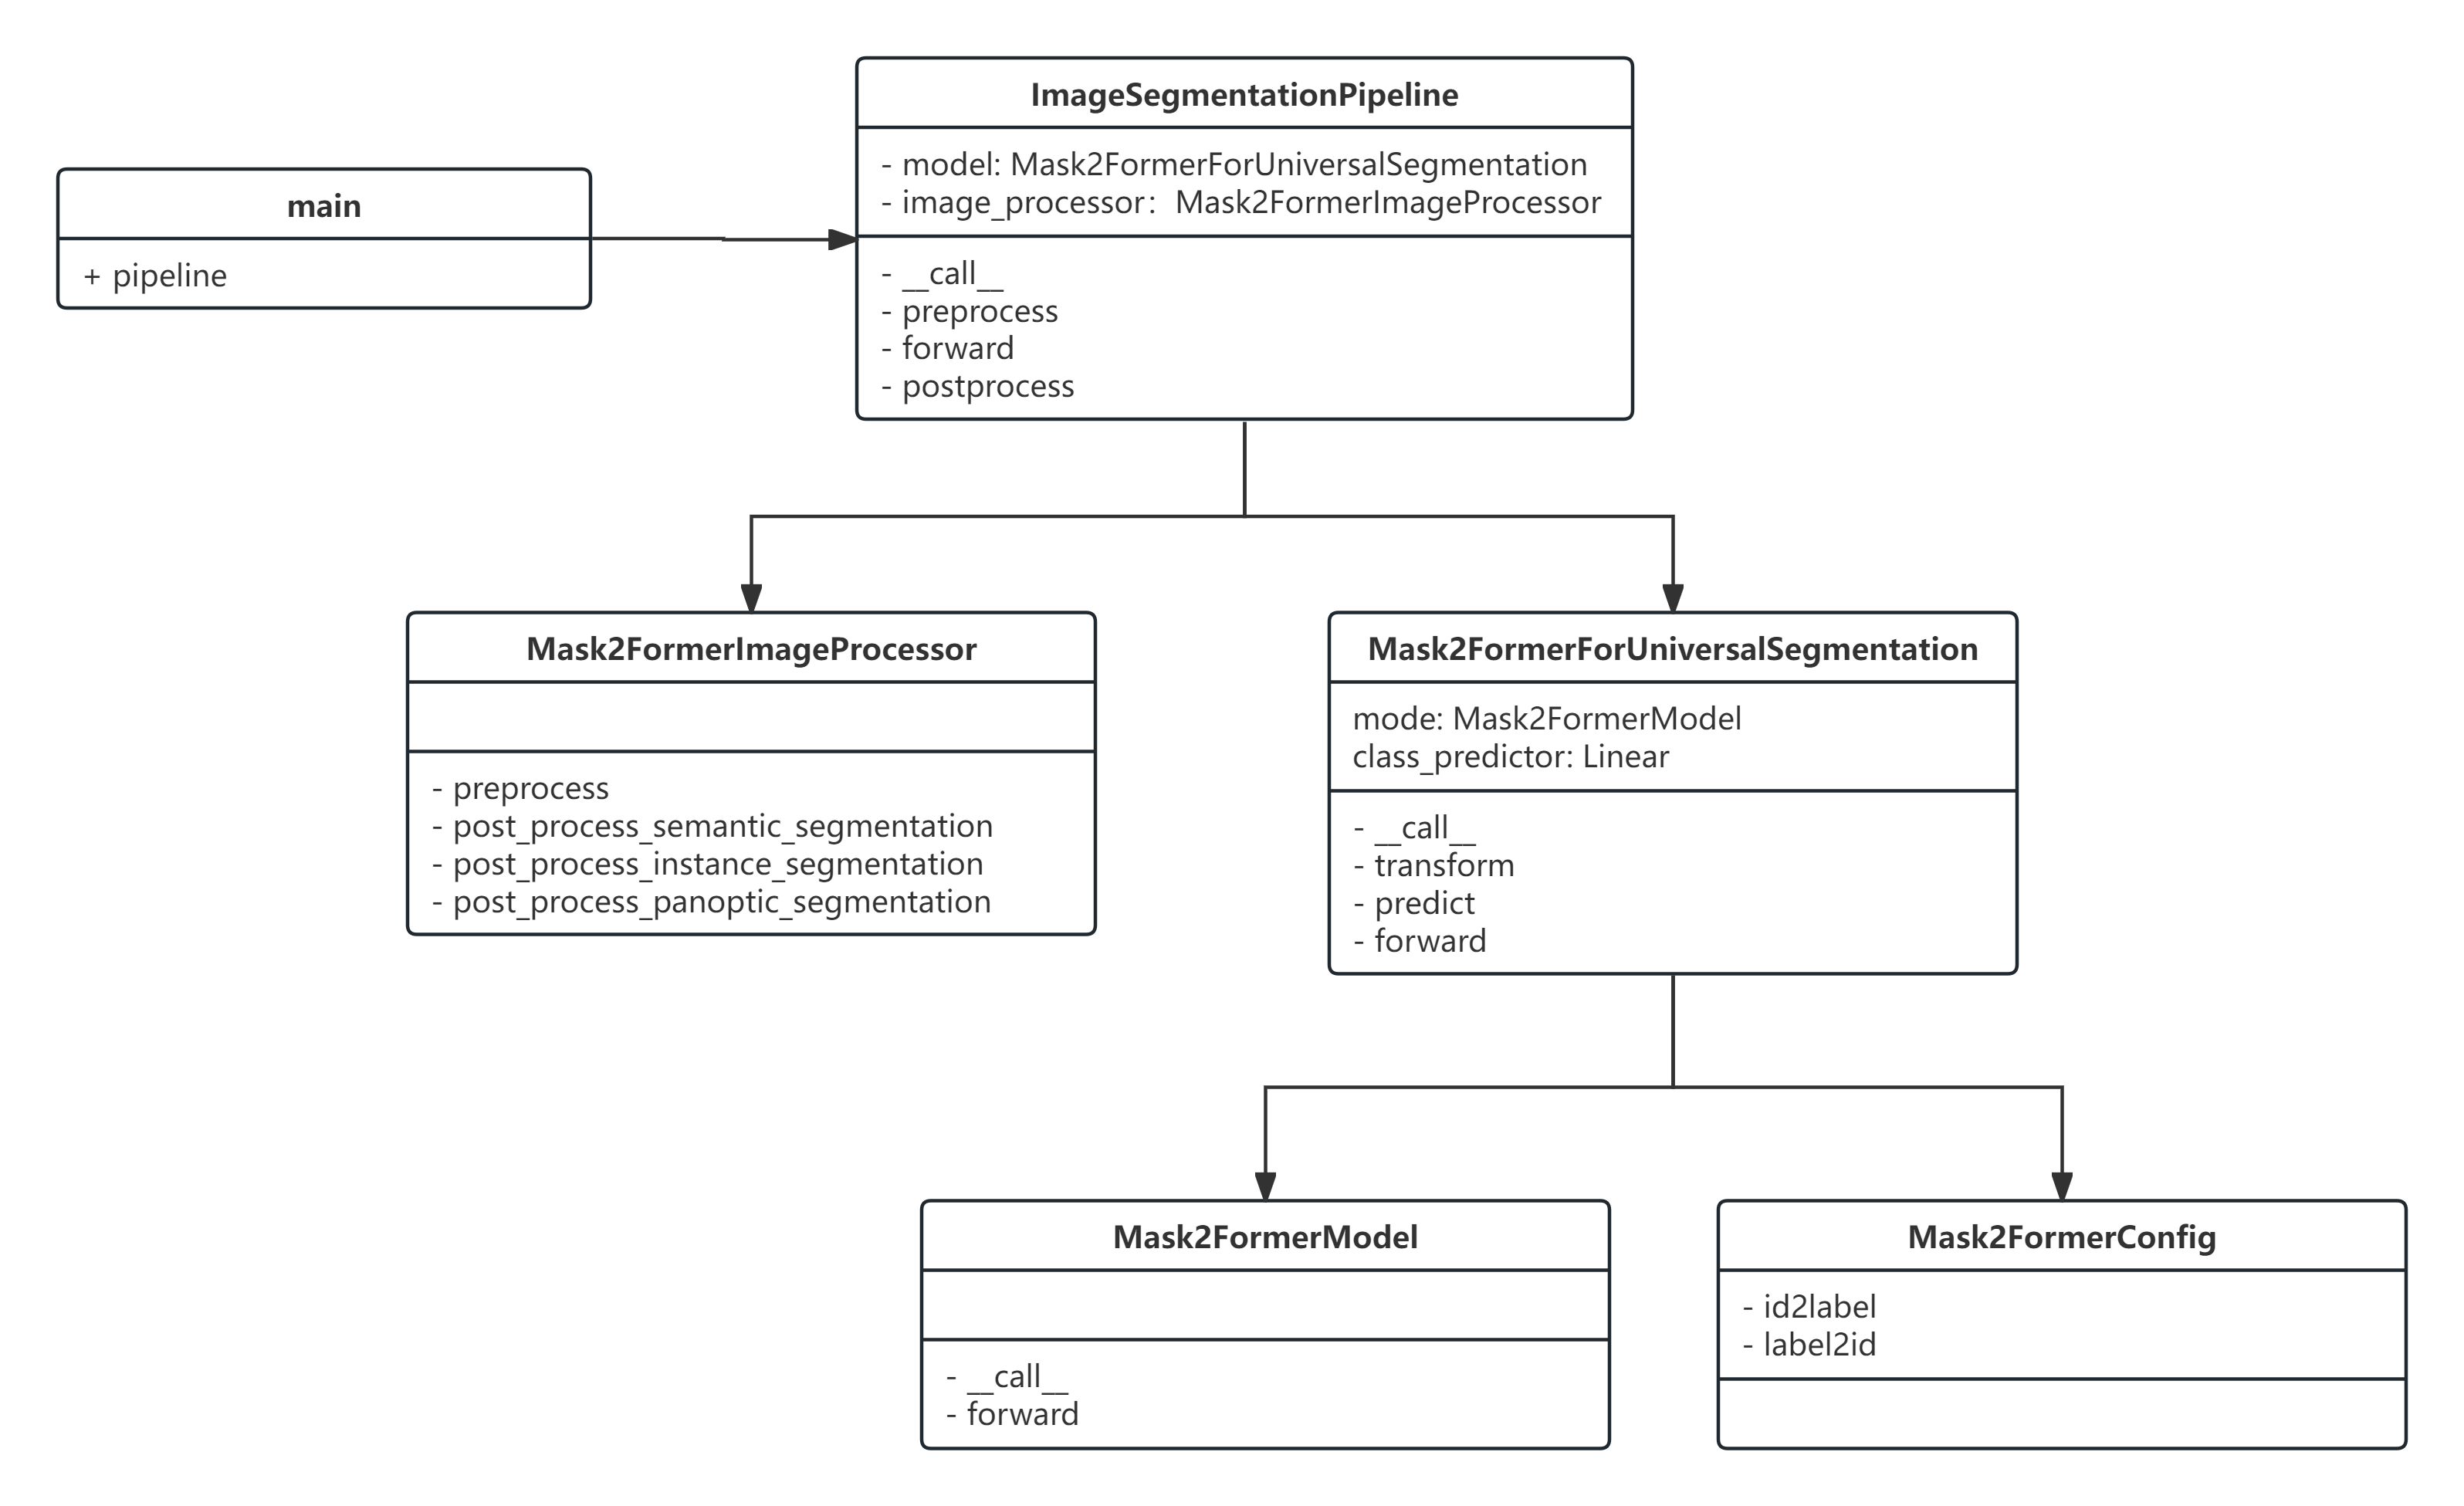

- 通过代码认识ImageSegmentationPipeline类及其协作类结构

In [5]:
from transformers import pipeline
from PIL import Image
pipe = pipeline("image-segmentation", model="F:/03Models/mask2former-swin-large-coco-instance")
print("Pipeline类：", type(pipe))
print("\t|- 分隔模型类：", type(pipe.model))
print("\t\t|- 配置类：", type(pipe.model.config))
print("\t\t|- 特征模型类：", type(pipe.model.model))
print("\t|- 图像处理器类：", type(pipe.image_processor))

# 预处理
model_inputs = pipe.preprocess("./imgs/000000039769.jpg")
# 推理
model_outputs = pipe.forward(model_inputs)
# 后处理
results = pipe.postprocess(model_outputs)
print(results)

C:\Program Files\Python313\Lib\site-packages\transformers\image_processing_base.py:417: UserWarning: The following named arguments are not valid for `Mask2FormerImageProcessor.__init__` and were ignored: '_max_size', 'reduce_labels'
  image_processor = cls(**image_processor_dict)
Device set to use cuda:0


Pipeline类： <class 'transformers.pipelines.image_segmentation.ImageSegmentationPipeline'>
	|- 分隔模型类： <class 'transformers.models.mask2former.modeling_mask2former.Mask2FormerForUniversalSegmentation'>
		|- 配置类： <class 'transformers.models.mask2former.configuration_mask2former.Mask2FormerConfig'>
		|- 特征模型类： <class 'transformers.models.mask2former.modeling_mask2former.Mask2FormerModel'>
	|- 图像处理器类： <class 'transformers.models.mask2former.image_processing_mask2former.Mask2FormerImageProcessor'>


`label_ids_to_fuse` unset. No instance will be fused.


[{'score': 0.99046, 'label': 'cat', 'mask': <PIL.Image.Image image mode=L size=640x480 at 0x2730F4945D0>}, {'score': 0.963727, 'label': 'sofa', 'mask': <PIL.Image.Image image mode=L size=640x480 at 0x273BECCDA50>}, {'score': 0.995877, 'label': 'cat', 'mask': <PIL.Image.Image image mode=L size=640x480 at 0x273BECCCCD0>}, {'score': 0.968649, 'label': 'remote', 'mask': <PIL.Image.Image image mode=L size=640x480 at 0x273BECCDB50>}, {'score': 0.996842, 'label': 'remote', 'mask': <PIL.Image.Image image mode=L size=640x480 at 0x273BECCD8D0>}]


- 代码说明：
    - 输出的结果与上面的模型应用例子一样，这里不可视化处理。

- a. 加载模块

In [6]:
from transformers import Mask2FormerImageProcessor, Mask2FormerForUniversalSegmentation
import torch
from PIL import Image
import PIL
import matplotlib.pyplot as plt
import numpy as np
plt.rcParams["font.family"] = ["Microsoft YaHei"]

- b. 加载模型（包含凸显处理器）

In [7]:
# 加载图像处理器
processor = Mask2FormerImageProcessor.from_pretrained("F:/03Models/mask2former-swin-large-coco-instance")
# 加载目标分割模型（模型后缀instance表示实例分割）
model = Mask2FormerForUniversalSegmentation.from_pretrained("F:/03Models/mask2former-swin-large-coco-instance")

- c. 预处理

In [8]:
img_file = "./imgs/000000039769.jpg"

####################直接调用processor
"""
Mask2FormerImageProcessor的preprocess函数与Mask2FormerForUniversalSegmentation的preprocess函数不同。
Mask2FormerImageProcessor的preprocess函数的输入要求是：ImageInput
    PIL.Image.Image
    np.ndarray, 
    "torch.Tensor", 
    list["PIL.Image.Image"], 
    list[np.ndarray], 
    list["torch.Tensor"]
"""
model_inputs = processor(Image.open(img_file), return_tensors="pt")  # 使用oneform配置，需要指定task_inputs = subtask参数。
# print(model_inputs)
# print(model_inputs["pixel_values"].shape)
# print("*" * 100)
####################手工实现
# 1. 从指定的图像源加载图像
image = Image.open(img_file)
image = PIL.ImageOps.exif_transpose(image)  # 一般不需要
image = image.convert("RGB")   # 一般不需要，主要考虑png图像。
# 2. 图像处理器的处理过程，下面实现等价于outputs = processor([image], return_tensors="pt")
# image = np.array(image)
# resize
width = 384 # 来自preprocessor_config.json问价
height = 384 # 来自preprocessor_config.json问价
resample = 2 # 来自preprocessor_config.json问价
resized_image = image.resize((width, height), resample=resample)
resized_image = np.array(resized_image)
# rescale
rescale = 0.00392156862745098   # 来自preprocessor_config.json文件
rescale_image = resized_image.astype(np.float64) * rescale
# normalize
mean = np.array([
    0.48500001430511475,
    0.4560000002384186,
    0.4059999883174896
], dtype=np.float64)
std = np.array([
    0.2290000021457672,
    0.2239999920129776,
    0.22499999403953552
], dtype=np.float64)
normalize_image = (rescale_image - mean) / std
# 转换为torch的格式【batch_size, channels, height, width】 = [NCHW]
inputs_pixels = normalize_image.transpose(2, 0, 1) # 注意前面是float32与float64的计算结果是有点差异的（计算误差），

inputs_masks = np.zeros((height, width), dtype=np.int64)
inputs_masks[:, :] = 1
# 为了与图像处理器保持一致格式，所以转换为字典（数据转换为张量）
model_inputs = {
    "pixel_values": torch.tensor(inputs_pixels, dtype=torch.float32).unsqueeze(0), 
    "pixel_mask": torch.tensor(inputs_masks).unsqueeze(0)
}
print(model_inputs)

{'pixel_values': tensor([[[[ 0.3138,  0.3652,  0.3994,  ..., -0.3027, -0.3883, -0.3369],
          [ 0.2796,  0.3481,  0.5022,  ..., -0.3883, -0.3369, -0.3712],
          [ 0.3309,  0.3994,  0.4508,  ..., -0.3541, -0.3541, -0.4054],
          ...,
          [ 1.8722,  1.8893,  1.7865,  ...,  1.1700,  1.0502,  0.9817],
          [ 1.8208,  1.8550,  1.7009,  ...,  0.4679,  0.2282, -0.0116],
          [ 1.9578,  1.8550,  1.6153,  ..., -0.4739, -0.6623, -0.7650]],

         [[-1.5980, -1.6331, -1.6681,  ..., -1.8431, -1.7906, -1.8256],
          [-1.5980, -1.5980, -1.5455,  ..., -1.7731, -1.8081, -1.7731],
          [-1.5455, -1.5455, -1.5630,  ..., -1.7206, -1.7731, -1.7731],
          ...,
          [-0.4076, -0.3725, -0.4601,  ..., -0.9678, -1.0553, -1.0553],
          [-0.5126, -0.4426, -0.5476,  ..., -1.3704, -1.4755, -1.6506],
          [-0.3025, -0.4251, -0.6702,  ..., -1.6856, -1.7381, -1.7381]],

         [[-0.7761, -0.6541, -0.5844,  ..., -1.1247, -1.1247, -1.1770],
          [-0

- 代码说明；
    - 上面手工实现与图像处理器的输出结果一致。但是需要注意在像素处理的时候，建议使用np.float64。因为在配置文件中mean，std，rescale的精度都超过np.float32。

- d. 模型推理调用
    - 在该过程中，我们没有深入分析Mask2FormerForUniversalSegmentation的内部实现，而是直接调用。
    - 在该过程的重点是认识Mask2FormerForUniversalSegmentation的输出格式与处理。

In [9]:
model_outputs = model(**model_inputs)
print(dict(model_outputs).keys())

dict_keys(['class_queries_logits', 'masks_queries_logits', 'encoder_last_hidden_state', 'pixel_decoder_last_hidden_state', 'transformer_decoder_last_hidden_state'])


- 代码说明：
    - model的参数，主要输入了两个参数pixel_values与pixel_mask

- e. 后处理
    - 在图像处理器中，提供了三个后处理函数：
        - 语义分割：`post_process_semantic_segmentation`
        - 实例分割：`post_process_instance_segmentation`
        - 全景分割：`post_process_panoptic_segmentation`
    - 我们直接调用，不深入分析三个函数的具体实现。

- 语义分割处理函数定义：`post_process_semantic_segmentation`
```python
def post_process_semantic_segmentation(
    self, 
    outputs, 
    target_sizes: Optional[list[tuple[int, int]]] = None
) -> "torch.Tensor":
```
- 实例分割处理函数定义：`post_process_instance_segmentation`
```python
def post_process_instance_segmentation(
        self,
        outputs,
        threshold: float = 0.5,
        mask_threshold: float = 0.5,
        overlap_mask_area_threshold: float = 0.8,
        target_sizes: Optional[list[tuple[int, int]]] = None,
        return_coco_annotation: Optional[bool] = False,
        return_binary_maps: Optional[bool] = False,
    ) -> list[dict]:
```
- 全景分割处理函数定义：`post_process_panoptic_segmentation`
```python
def post_process_panoptic_segmentation(
        self,
        outputs,
        threshold: float = 0.5,
        mask_threshold: float = 0.5,
        overlap_mask_area_threshold: float = 0.8,
        label_ids_to_fuse: Optional[set[int]] = None,
        target_sizes: Optional[list[tuple[int, int]]] = None,
    ) -> list[dict]:
```

- 实例分割调用

In [10]:
# target_sizes = [(image.height, image.width)]
print([(image.height, image.width)])
target_sizes = [image.size[::-1]]
print(target_sizes)
instance_segment = processor.post_process_instance_segmentation(
    model_outputs, 
    target_sizes=target_sizes, 
    threshold=0.90,
    mask_threshold=0.5
)[0]  # 取第一个图片的分割（我们输入的也仅仅一张图像）
print(instance_segment)

[(480, 640)]
[(480, 640)]
{'segmentation': tensor([[4., 4., 4.,  ..., 4., 4., 4.],
        [4., 4., 4.,  ..., 4., 4., 4.],
        [4., 4., 4.,  ..., 4., 4., 4.],
        ...,
        [4., 4., 4.,  ..., 4., 4., 4.],
        [4., 4., 4.,  ..., 4., 4., 4.],
        [4., 4., 4.,  ..., 4., 4., 4.]]), 'segments_info': [{'id': 0, 'label_id': 65, 'was_fused': False, 'score': 0.98457}, {'id': 1, 'label_id': 15, 'was_fused': False, 'score': 0.964723}, {'id': 2, 'label_id': 15, 'was_fused': False, 'score': 0.951867}, {'id': 3, 'label_id': 65, 'was_fused': False, 'score': 0.946752}, {'id': 4, 'label_id': 57, 'was_fused': False, 'score': 0.908847}]}


- 代码说明；
    - 输出结果是一张分割图：segmentation，以及相关的分割信息segments_info，分隔信息中包含如下数据：
        - id：分隔图中的索引（从1开始的目标数量编号）。
        - label_id：分隔目标的分类ID。可以转换为可阅读的目标分类名。
        - was_fused：是否进行分割目标融合，需要在图像处理器配置label_ids_to_fuse字段
        - score：识别目标正确的概率（得分）。
    - 下面我们进行可视化
        - segmentation的大小与原图像大小一致。创建一个与segmentation大小一样的空图像。
        - 使用segmentation矩阵的逻辑运算，并转换为uint8，并乘以255，转换为灰度图显示。

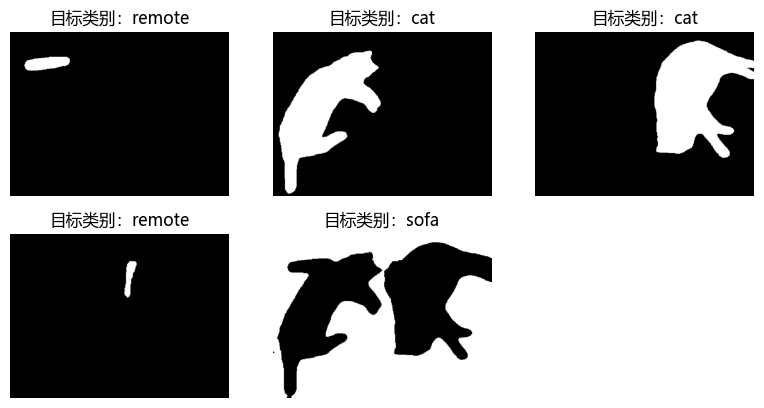

In [11]:
seg = instance_segment["segmentation"].numpy()
count = len(instance_segment["segments_info"])
cols = 3
rows = count // cols + 1
plt.figure(figsize=(3.2 * cols, 2.4 * rows))
for i, obj in  enumerate(instance_segment["segments_info"]):
    idx = obj["id"]
    mask = (seg==idx)
    visual_mask = (mask * 255).astype(np.uint8)
    plt.subplot(rows, cols, i+1)
    plt.imshow(visual_mask,cmap="gray")
    plt.title(F"目标类别：{model.config.id2label[obj["label_id"]]}")
    plt.axis(False)
plt.show()

- 全景分割调用

In [12]:
target_sizes = [(image.height, image.width)]
panopti_segment = processor.post_process_panoptic_segmentation(
    model_outputs, 
    target_sizes=target_sizes, 
    threshold=0.9,
)[0]  # 取第一个图片的分割（我们输入的也仅仅一张图像）
print(panopti_segment)

`label_ids_to_fuse` unset. No instance will be fused.


{'segmentation': tensor([[2, 2, 2,  ..., 2, 2, 2],
        [2, 2, 2,  ..., 2, 2, 2],
        [2, 2, 2,  ..., 2, 2, 2],
        ...,
        [2, 2, 2,  ..., 2, 2, 2],
        [2, 2, 2,  ..., 2, 2, 2],
        [2, 2, 2,  ..., 2, 2, 2]], dtype=torch.int32), 'segments_info': [{'id': 1, 'label_id': 15, 'was_fused': False, 'score': 0.990473}, {'id': 2, 'label_id': 57, 'was_fused': False, 'score': 0.963791}, {'id': 3, 'label_id': 15, 'was_fused': False, 'score': 0.995871}, {'id': 4, 'label_id': 65, 'was_fused': False, 'score': 0.968681}, {'id': 5, 'label_id': 65, 'was_fused': False, 'score': 0.996843}]}


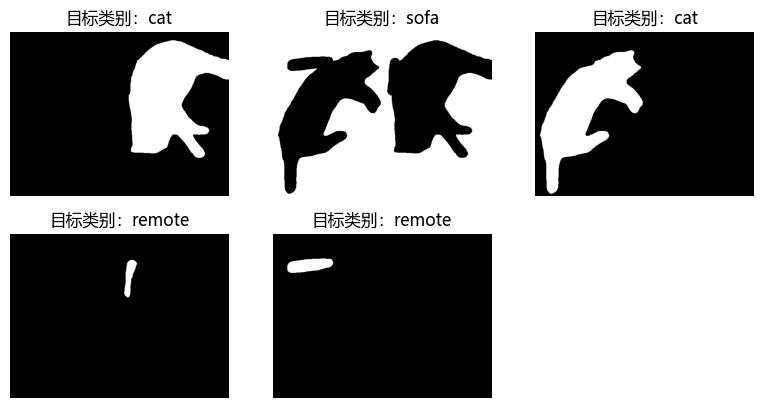

In [13]:
seg = panopti_segment["segmentation"].numpy()
count = len(panopti_segment["segments_info"])
cols = 3
rows = count // cols + 1
plt.figure(figsize=(3.2 * cols, 2.4 * rows))
for i, obj in  enumerate(panopti_segment["segments_info"]):
    idx = obj["id"]
    mask = (seg==idx)
    visual_mask = (mask * 255).astype(np.uint8)
    plt.subplot(rows, cols, i+1)
    plt.imshow(visual_mask,cmap="gray")
    plt.title(F"目标类别：{model.config.id2label[obj["label_id"]]}")
    plt.axis(False)
plt.show()

- 语义分割调用

In [14]:
target_sizes = [(image.height, image.width)]
semantic_segment = processor.post_process_semantic_segmentation(
    model_outputs, 
    target_sizes=target_sizes
)[0]  # 取第一个图片的分割（我们输入的也仅仅一张图像）
print(semantic_segment)

tensor([[57, 57, 57,  ..., 57, 57, 57],
        [57, 57, 57,  ..., 57, 57, 57],
        [57, 57, 57,  ..., 57, 57, 57],
        ...,
        [57, 57, 57,  ..., 57, 57, 57],
        [57, 57, 57,  ..., 57, 57, 57],
        [57, 57, 57,  ..., 57, 57, 57]])


<function matplotlib.pyplot.show(close=None, block=None)>

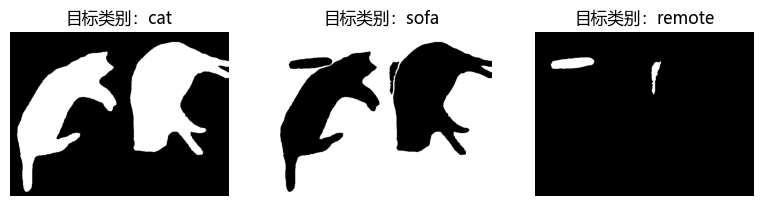

In [15]:
clses = np.unique(semantic_segment)
cols = 3
count = len(clses)
rows = count // cols + 1
plt.figure(figsize=(3.2 * cols, 2.4 * rows))
for i, cls in  enumerate(clses):
    mask = (semantic_segment.numpy() == cls)
    visual_mask = (mask * 255).astype(np.uint8)
    plt.subplot(rows, cols, i+1)
    plt.imshow(visual_mask,cmap="gray")
    plt.title(F"目标类别：{model.config.id2label[cls]}")
    plt.axis(False)
plt.show

### (4) 总结

- 在实例分割处理中，threshold参数设置为0.5，效果很差，但是在全景分割处理中threshold=0.5分隔效果比较理想。
    - 因为全景分割是语义分割与实例分割的结合。

## 5.4. 全景分隔模型应用

### (1) 模型下载

- 下载：
    - `git clone https://www.modelscope.cn/facebook/detr-resnet-101-panoptic.git`
    - `git clone https://www.modelscope.cn/facebook/mask2former-swin-large-coco-panoptic.git`
    - `git clone https://huggingface.co/tue-mps/coco_panoptic_eomt_large_640`
    - `git clone https://huggingface.co/tue-mps/ade20k_semantic_eomt_large_512`

### (2) 模型应用

- detr-resnet-101-panoptic模型使用的是DETR算法。
- mask2former-swin-large-coco-panoptic模型使用的是mask2former算法。

In [16]:
import os
# 在导入其他模块前设置
os.environ['PYTHONWARNINGS'] = 'ignore'
from transformers import pipeline

print("1. coco_panoptic_eomt_large_640模型：")
pipe1 = pipeline("image-segmentation", model="F:/03Models/coco_panoptic_eomt_large_640")
print("\tpipeline类型：", type(pipe1))
print("\t\t|-侦测模型：", type(pipe1.model))
print("\t\t\t|-模型配置：", type(pipe1.model.config))
print("\t\t|-处理器：", type(pipe1.image_processor))

print("2. mask2former-swin-large-coco-panoptic模型：")
pipe2 = pipeline("image-segmentation", model="F:/03Models/mask2former-swin-large-coco-panoptic")
print("\tpipeline类型：", type(pipe2))
print("\t\t|-侦测模型：", type(pipe2.model))
print("\t\t\t|-模型配置：", type(pipe2.model.config))
print("\t\t\t|-底层模型：", type(pipe2.model.model))
print("\t\t|-处理器：", type(pipe2.image_processor))

Device set to use cuda:0


1. coco_panoptic_eomt_large_640模型：
	pipeline类型： <class 'transformers.pipelines.image_segmentation.ImageSegmentationPipeline'>
		|-侦测模型： <class 'transformers.models.eomt.modeling_eomt.EomtForUniversalSegmentation'>
			|-模型配置： <class 'transformers.models.eomt.configuration_eomt.EomtConfig'>
		|-处理器： <class 'transformers.models.eomt.image_processing_eomt_fast.EomtImageProcessorFast'>
2. mask2former-swin-large-coco-panoptic模型：


Device set to use cuda:0


	pipeline类型： <class 'transformers.pipelines.image_segmentation.ImageSegmentationPipeline'>
		|-侦测模型： <class 'transformers.models.mask2former.modeling_mask2former.Mask2FormerForUniversalSegmentation'>
			|-模型配置： <class 'transformers.models.mask2former.configuration_mask2former.Mask2FormerConfig'>
			|-底层模型： <class 'transformers.models.mask2former.modeling_mask2former.Mask2FormerModel'>
		|-处理器： <class 'transformers.models.mask2former.image_processing_mask2former.Mask2FormerImageProcessor'>


- 代码说明：
    - 从上面两个模型的输出看出，不同的模型采用不同的模型算法。
    - coco_panoptic_eomt_large_640模型使用的是EomtImageProcessorFast图像处理器

### (3) 模型分析

- 我们在默认调用pipeline进行推理的时候，图像处理器一般默认调用哪个函数处理？我们下面用一段代码来分析。
    - 提示：在模型算法类中含Universal的是通用分隔模型，支持三种分隔算法的实现。

In [17]:
from transformers import pipeline
pipe = pipeline("image-segmentation", model="F:/03Models/coco_panoptic_eomt_large_640")
img_file = "./imgs/000000039769.jpg"
outputs = pipe(img_file)
print(outputs)

Device set to use cuda:0


[{'score': 0.99935, 'label': 'cat', 'mask': <PIL.Image.Image image mode=L size=640x480 at 0x273BED0C050>}, {'score': 0.998688, 'label': 'cat', 'mask': <PIL.Image.Image image mode=L size=640x480 at 0x273BED0C1D0>}, {'score': 0.954326, 'label': 'couch', 'mask': <PIL.Image.Image image mode=L size=640x480 at 0x273BED02D50>}, {'score': 0.997285, 'label': 'remote', 'mask': <PIL.Image.Image image mode=L size=640x480 at 0x273BED039D0>}, {'score': 0.99711, 'label': 'remote', 'mask': <PIL.Image.Image image mode=L size=640x480 at 0x273BED015D0>}]


- 代码说明：
    - Pipeline在默认情况下调用图像处理器的post_process_panoptic_segmentation函数进行后处理（默认是进行全景分割的）。
        - 可以通过参数来控制采用目标分割的算法：subtask
    - 我们从pipeline的调用结果与我们直接调用post_process_panoptic_segmentation的结果比较，pipeline还做了额外的处理。
        - 就是把分割图，按照类别转换为黑背mask图。转换原理很简单：
            - `segmentation = outputs["segmentation"]`：取出分割图   
            - `mask = (segmentation == segment["id"]) * 255`：转为为灰度图
            - `mask = Image.fromarray(mask.numpy().astype(np.uint8), mode="L")`：转换为PIL.Image格式
            - `label = self.model.config.id2label[segment["label_id"]]`：分隔的取出标签
            - `score = segment["score"]`：取出侦测目标的概率。
            - `annotation.append({"score": score, "label": label, "mask": mask})`：最后返回字典列表。

In [18]:
from transformers import pipeline
pipe = pipeline("image-segmentation", model="F:/03Models/coco_panoptic_eomt_large_640")
# pipe = pipeline("image-segmentation", model="F:/03Models/mask2former-swin-large-coco-panoptic")
# pipe = pipeline("image-segmentation", model="F:/03Models/ade20k_semantic_eomt_large_512")

img_file = "./imgs/000000039769.jpg"
outputs = pipe(img_file, subtask="instance")   # panoptic, instance, semantic
print(outputs)

Device set to use cuda:0
C:\Program Files\Python313\Lib\site-packages\transformers\pipelines\image_segmentation.py:194: UserWarning: The following named arguments are not valid for `EomtImageProcessorFast.post_process_instance_segmentation` and were ignored: 'mask_threshold', 'overlap_mask_area_threshold'
  outputs = fn(


[{'score': 0.976632, 'label': 'cat', 'mask': <PIL.Image.Image image mode=L size=640x480 at 0x273BE4DF4D0>}, {'score': 0.968333, 'label': 'cat', 'mask': <PIL.Image.Image image mode=L size=640x480 at 0x273BE4DEED0>}, {'score': 0.92254, 'label': 'couch', 'mask': <PIL.Image.Image image mode=L size=640x480 at 0x273BE4DEE50>}, {'score': 0.979213, 'label': 'remote', 'mask': <PIL.Image.Image image mode=L size=640x480 at 0x273BE4DEDD0>}, {'score': 0.972477, 'label': 'remote', 'mask': <PIL.Image.Image image mode=L size=640x480 at 0x273BE4DED50>}]


- 代码说明：
    - coco_panoptic_eomt_large_640模型在执行semantic处理的时候，后处理函数存在一些bug。

- a. 模型加载

In [19]:
from transformers import EomtForUniversalSegmentation, AutoImageProcessor, EomtImageProcessorFast
# model_dir = "F:/03Models/coco_panoptic_eomt_large_640"
model_dir = "F:/03Models/ade20k_semantic_eomt_large_512"

img_file = "./imgs/000000039769.jpg"

# processor = AutoImageProcessor.from_pretrained(model_dir, use_fast=True)  # 默认从配置文件获取信息
# processor = AutoImageProcessor.from_pretrained(model_dir)
# print(type(processor))

# processor = EomtImageProcessorFast.from_pretrained(model_dir, use_fast=False)
processor = EomtImageProcessorFast.from_pretrained(model_dir)
print(type(processor))
model = EomtForUniversalSegmentation.from_pretrained(model_dir)

<class 'transformers.models.eomt.image_processing_eomt_fast.EomtImageProcessorFast'>


- 代码说明：
    - 关于图像处理器加载的模式，下面四种方式都是一样加载fast模式：
        - `processor = AutoImageProcessor.from_pretrained(model_dir, use_fast=True)`
        - `processor = AutoImageProcessor.from_pretrained(model_dir)`
        - `processor = EomtImageProcessorFast.from_pretrained(model_dir, use_fast=False)`
        - `processor = EomtImageProcessorFast.from_pretrained(model_dir)`

- b. 图像预处理

In [20]:
from PIL import Image
image = Image.open(img_file)
inputs = processor(images=image, return_tensors="pt")
print(inputs)
print(inputs.pixel_values.shape) 

{'pixel_values': tensor([[[[ 0.2796,  0.3481,  0.3823,  ..., -0.3541, -0.4568, -0.4397],
          [ 0.2453,  0.3138,  0.2796,  ..., -0.3541, -0.4226, -0.2856],
          [ 0.1939,  0.4166,  0.3309,  ..., -0.1999, -0.4054, -0.4054],
          ...,
          [ 1.9235,  1.7523,  1.9064,  ...,  1.9064,  1.7180,  1.6667],
          [ 1.8379,  1.7865,  1.9235,  ...,  1.8722,  1.6838,  1.7352],
          [ 1.9578,  2.0777,  1.9749,  ...,  1.7865,  1.7523,  1.8722]],

         [[-1.5980, -1.5980, -1.6155,  ..., -1.8256, -1.9307, -1.9482],
          [-1.6506, -1.5805, -1.6681,  ..., -1.8957, -1.8606, -1.8782],
          [-1.6506, -1.4930, -1.6155,  ..., -1.8606, -1.8431, -1.8957],
          ...,
          [-0.3200, -0.5476, -0.3901,  ..., -0.7752, -0.9328, -0.9853],
          [-0.5301, -0.5826, -0.3550,  ..., -0.7752, -0.9153, -0.9153],
          [-0.2850, -0.1450, -0.3200,  ..., -0.7402, -0.7577, -0.7402]],

         [[-0.8284, -0.6541, -0.5495,  ..., -1.3164, -1.3861, -1.4559],
          [-0

- 代码说明：
    - 我们选择`ade20k_semantic_eomt_large_512`模型是因为其图像处理器在预处理图像时，生成patch_offsets信息。我们在下面推理需要使用该信息。
    - patch_offsets的作用说明；
        - patch_offsets是某些图像处理器（特别是用于 ViT、Swin Transformer等基于patch的模型的处理器）生成的数据中的一个字段。它在图像分割或目标检测任务中特别重要。
        - patch_offsets记录了原始图像中每个patch相对于原图的偏移量。简单来说，它告诉你每个图像块（patch）在原始大图中的起始位置。
        - patch_offsets可以将patch特征映射回原始图像空间。
        - patch_offsets在分割任务中重建完整掩码
        - patch_offsets可以处理图像边界的不完整 patches
    - 注意：
        - patch_offsets经常应用在全景分割的实例融合，处理多尺度特征。
        - 有些模型可能用 grid_offsets 或 patch_coordinates 代替
        - patch_offsets 的顺序与 pixel_values 中 patches 的顺序严格对应，上面处理的patches一共两个：`torch.Size([2, 3, 512, 512])`。

- c. 模型推理调用

In [21]:
import torch

# GPU使用处理
device = "cuda" if torch.cuda.is_available() else "cpu"
# 把模型移到GPU
model.to(device)
# 把图像像素数据移到GPU
pixel_values = inputs.pixel_values.to(device)

with torch.inference_mode():  # 这是进入推理模式：model.eval()， with torch.no_grad()调用的封装
    outputs = model(
        pixel_values=pixel_values, 
        patch_offsets=[offsets.to(device) for offsets in inputs.patch_offsets]
    )
print(outputs)   
print(outputs.keys())

EomtForUniversalSegmentationOutput(loss=None, class_queries_logits=tensor([[[ 1.5410, -3.8022, -0.7832,  ..., -3.9769, -3.1257, 10.4403],
         [ 1.5632, -4.7687, -1.1687,  ..., -2.7505, -3.5221, 10.9242],
         [ 0.1955, -3.0675, -1.4086,  ..., -2.9228, -3.8875, 10.8336],
         ...,
         [ 1.4763, -3.5512, -1.4345,  ..., -3.7446, -3.1079,  9.8558],
         [ 2.2099, -3.8225, -0.3391,  ..., -3.8006, -2.3692, 10.6683],
         [ 0.8137, -5.3624, -1.3049,  ..., -3.0319, -3.0665, 11.2727]],

        [[ 0.7411, -2.6592, -1.2786,  ..., -4.0981, -3.4660,  9.8530],
         [ 0.4890, -2.3714, -2.3422,  ..., -1.8424, -3.4852,  9.4507],
         [ 1.1676, -2.5355, -1.4957,  ..., -3.4689, -4.0662, 10.2509],
         ...,
         [ 1.7370, -2.8463, -1.7499,  ..., -4.0083, -3.8447, 10.2786],
         [ 1.6460, -3.1314, -0.9085,  ..., -4.0383, -3.1711, 10.1984],
         [ 1.4610, -5.1387, -1.4116,  ..., -3.7771, -3.5720, 10.9819]]],
       device='cuda:0'), masks_queries_logits=ten

- 代码说明：
    - 输出是继承dict的EomtForUniversalSegmentationOutput类型，其中包含四个字段：
        - 'class_queries_logits'
        - 'masks_queries_logits'
        - 'last_hidden_state'
        - 'patch_offsets'

- d. 后处理 - 语义分割

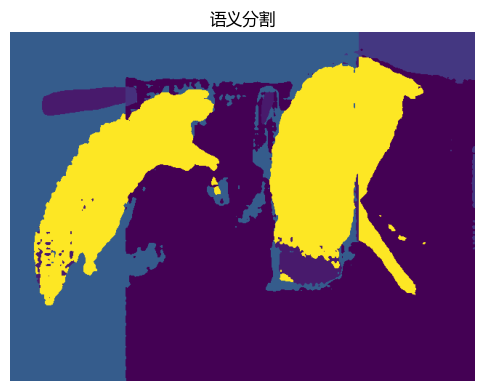

In [22]:
import matplotlib.pyplot as plt
plt.rcParams["font.family"] = ["Microsoft YaHei"]

original_image_sizes = [(image.height, image.width)]

# 语义分割处理
predictions = processor.post_process_semantic_segmentation(
    outputs,
    target_sizes=original_image_sizes,
)
# 可视化
plt.figure(figsize=(6, 4.8))
plt.imshow(predictions[0].cpu())
plt.axis("off")
plt.title("语义分割")
plt.show()

- 代码说明：
    - 对语义分割来说，有的算法是需要patch_offsets信息的。

- e. 后处理 - 实例分割

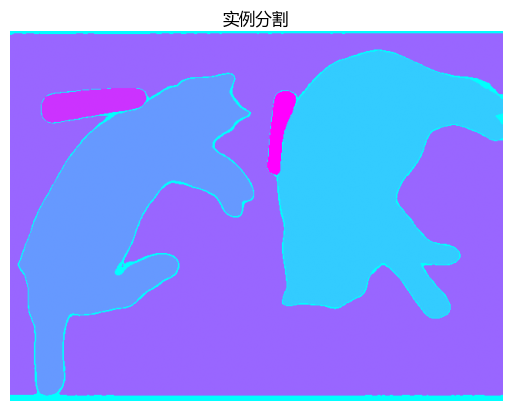

In [23]:
model_dir = "F:/03Models/coco_panoptic_eomt_large_640"
img_file = "./imgs/000000039769.jpg"

processor = EomtImageProcessorFast.from_pretrained(model_dir)
model = EomtForUniversalSegmentation.from_pretrained(model_dir)

image = Image.open(img_file)
inputs = processor(images=image, return_tensors="pt").to(device)
inputs = inputs.to(device)
model.to(device)

with torch.inference_mode():
    outputs = model(**inputs)

# 原图像尺寸
original_image_sizes = [(image.height, image.width)]

# 推理
predictions = processor.post_process_instance_segmentation(
    outputs,
    target_sizes=original_image_sizes,
)

# 可视化
plt.imshow(predictions[0]["segmentation"].cpu(), cmap="cool")  # 使用imshow的cmap实现自动颜色映射
plt.axis("off")
plt.title("实例分割")
plt.show()

- f. 后处理 - 全景分割

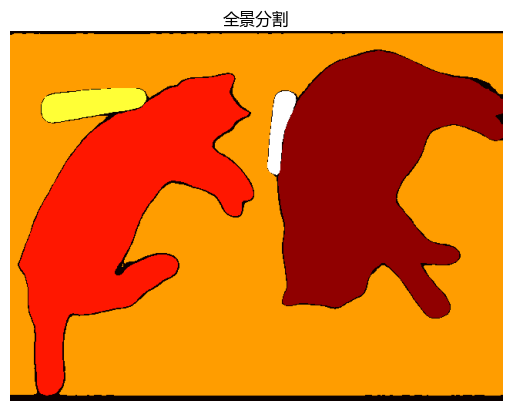

In [24]:
# 推理
predictions = processor.post_process_panoptic_segmentation(
    outputs,
    target_sizes=original_image_sizes,
)

# 可视化
plt.imshow(predictions[0]["segmentation"].cpu(), cmap="hot")
plt.axis("off")
plt.title("全景分割")
plt.show()

## 5.5. 通用分隔模型应用

- 通用模型：
    - Mask2Former
    - OneFormer

- 在前面我们看见并不是每个分隔模型都同时支持语义，实例与全景分割的。通用分隔模型表示可以同时支持这三种分隔方式。

### (1) 模型下载

- 下载指令；
    - `git clone https://huggingface.co/shi-labs/oneformer_coco_swin_large`
    - `git clone https://huggingface.co/facebook/mask2former-swin-large-cityscapes-semantic`

### (2) 模型应用 - mask2former

- Mask2Former算法模型：
    - `mask2former-swin-large-cityscapes-semantic`

In [25]:
from transformers import pipeline  # AutoImageProcessor, Mask2FormerForUniversalSegmentation
from  PIL import Image
import matplotlib.pyplot as plt
import numpy as np

plt.rcParams["font.family"] = ["Microsoft YaHei"]

model_dir = "F:/03Models/mask2former-swin-large-cityscapes-semantic"
img_file = "./imgs/Cityscapes.png"

pipe = pipeline(task="image-segmentation", model=model_dir)
image = Image.open(img_file)

seg_semantic = pipe(image, subtask="semantic")
seg_instance = pipe(image, subtask="instance", threhold=9.5)
seg_panoptic = pipe(image, subtask="panoptic", threhold=9.5)
print(seg_instance)
print("语义分割目标数：", len(seg_semantic))
print("实例分割目标数：", len(seg_instance))
print("全景分割目标数：", len(seg_panoptic))

Device set to use cuda:0
`label_ids_to_fuse` unset. No instance will be fused.


[{'score': 0.98688, 'label': 'road', 'mask': <PIL.Image.Image image mode=L size=676x338 at 0x2737D366A50>}, {'score': 0.97677, 'label': 'traffic light', 'mask': <PIL.Image.Image image mode=L size=676x338 at 0x2737D367E50>}, {'score': 0.940819, 'label': 'vegetation', 'mask': <PIL.Image.Image image mode=L size=676x338 at 0x2737D364B50>}, {'score': 0.931118, 'label': 'sidewalk', 'mask': <PIL.Image.Image image mode=L size=676x338 at 0x2737D364950>}, {'score': 0.968785, 'label': 'sky', 'mask': <PIL.Image.Image image mode=L size=676x338 at 0x2737D367DD0>}, {'score': 0.949217, 'label': 'truck', 'mask': <PIL.Image.Image image mode=L size=676x338 at 0x2737D366ED0>}, {'score': 0.979274, 'label': 'car', 'mask': <PIL.Image.Image image mode=L size=676x338 at 0x2737D3647D0>}, {'score': 0.975016, 'label': 'building', 'mask': <PIL.Image.Image image mode=L size=676x338 at 0x2737D364550>}]
语义分割目标数： 11
实例分割目标数： 8
全景分割目标数： 10


- 代码说明：
    - 通过配置文件知道，核心识别目标是1000种类别，但是分割的目标支持是19中类别。

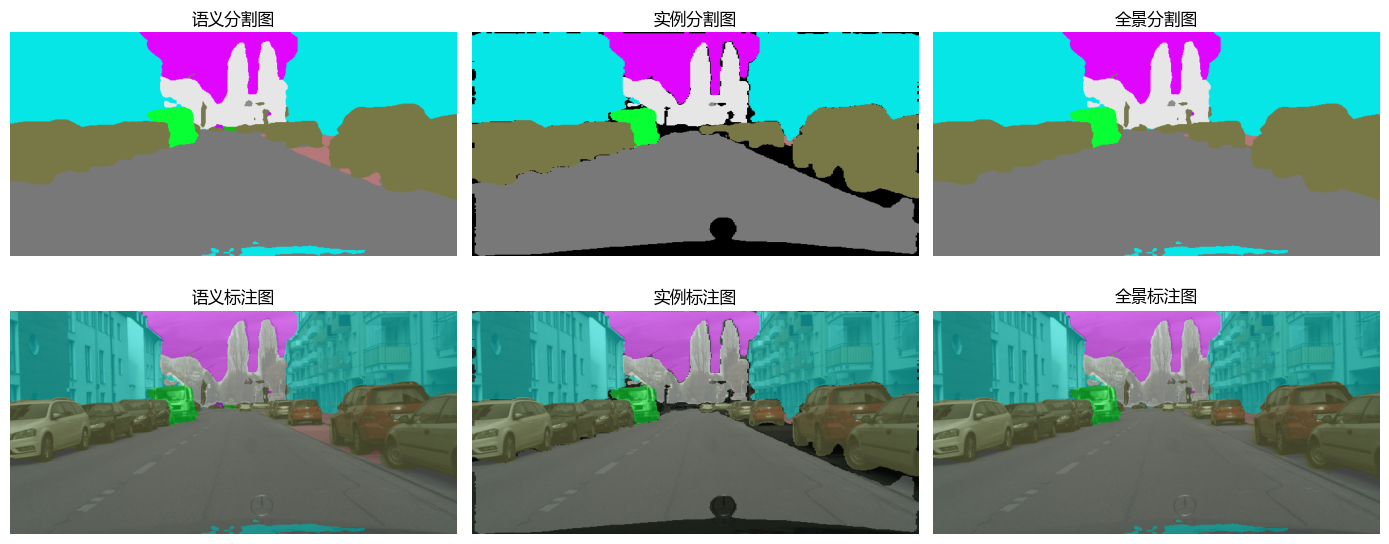

In [26]:
def visual_seg(outputs):
    # 定义20个颜色模版（目标分割的类型在配置文件知道是19种类别）
    palette = np.array(
        [[120, 120, 120], [180, 120, 120], [6, 230, 230], [80, 50, 50],
        [4, 200, 3], [120, 120, 80], [140, 140, 140], [204, 5, 255],
        [230, 230, 230], [4, 250, 7], [224, 5, 255], [235, 255, 7],
        [150, 5, 61], [120, 120, 70], [8, 255, 51], [255, 6, 82],
        [143, 255, 140], [204, 255, 4], [255, 51, 7], [204, 70, 3]])
    w, h = outputs[0]["mask"].size
    img_mask = np.zeros((h, w, 3), dtype=np.uint8)
    for a_obj in outputs:
        score = a_obj["score"]
        label = a_obj["label"]
        mask  = a_obj["mask"]
        label_id = pipe.model.config.label2id[label] 
        mask  = np.array(mask)  # 转换为numpy数组进行运算操作
        img_mask[mask==255, :] = palette[label_id]  # 把图像中mask为255对应的位置替换成模版中对应类别的颜色。
    return img_mask

img_semantic = visual_seg(seg_semantic)
img_instance = visual_seg(seg_instance)
img_panoptic = visual_seg(seg_panoptic)

img = np.array(image)

fuse_semantic = (img * 0.5 + img_semantic * 0.5).astype(np.uint8)
fuse_instance = (img * 0.5 + img_instance * 0.5).astype(np.uint8)
fuse_panoptic = (img * 0.5 + img_panoptic * 0.5).astype(np.uint8)

rows = 2
cols = 3

images = [img_semantic, img_instance, img_panoptic, fuse_semantic, fuse_instance, fuse_panoptic]
titles = ["语义分割图", "实例分割图", "全景分割图", "语义标注图", "实例标注图", "全景标注图"]
plt.figure(figsize=(rows * 7, cols * 2))
for r in range(rows):
    for c in range(cols):
        plt.subplot(rows, cols, cols * r + c + 1)
        plt.imshow(images[cols * r + c])
        plt.axis("off")
        plt.title(titles[cols * r + c])
plt.tight_layout()
plt.show()

- 代码说明：
    - 实例分割是按照目标来分割的，在目标之间可能存在缝隙。语义分割与全景分割不存在这种缝隙的情况。

### (3) 模型应用 - oneformer_coco_swin_large

- oneformer算法模型：
    - `oneformer_coco_swin_large`

In [27]:
from transformers import pipeline  # AutoImageProcessor, Mask2FormerForUniversalSegmentation
from  PIL import Image
import matplotlib.pyplot as plt
import numpy as np

plt.rcParams["font.family"] = ["Microsoft YaHei"]

model_dir = "F:/03Models/oneformer_coco_swin_large"
img_file = "./imgs/000000039769.jpg"

pipe = pipeline(task="image-segmentation", model=model_dir)
image = Image.open(img_file)

seg_semantic = pipe(image, subtask="semantic")
seg_instance = pipe(image, subtask="instance", threhold=9.5)
seg_panoptic = pipe(image, subtask="panoptic", threhold=9.5)
print(seg_instance)
print("语义分割目标数：", len(seg_semantic))
print("实例分割目标数：", len(seg_instance))
print("全景分割目标数：", len(seg_panoptic))

C:\Program Files\Python313\Lib\site-packages\transformers\image_processing_base.py:417: UserWarning: The following named arguments are not valid for `OneFormerImageProcessor.__init__` and were ignored: '_max_size', 'reduce_labels'
  image_processor = cls(**image_processor_dict)
Device set to use cuda:0
C:\Program Files\Python313\Lib\site-packages\torch\functional.py:554: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\pytorch\aten\src\ATen\native\TensorShape.cpp:4316.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]
`label_ids_to_fuse` unset. No instance will be fused.


[{'score': 0.999416, 'label': 'cat', 'mask': <PIL.Image.Image image mode=L size=640x480 at 0x27301885550>}, {'score': 0.999176, 'label': 'cat', 'mask': <PIL.Image.Image image mode=L size=640x480 at 0x27301884950>}, {'score': 0.998459, 'label': 'remote', 'mask': <PIL.Image.Image image mode=L size=640x480 at 0x27301884CD0>}, {'score': 0.996546, 'label': 'remote', 'mask': <PIL.Image.Image image mode=L size=640x480 at 0x27301885AD0>}, {'score': 0.970015, 'label': 'couch', 'mask': <PIL.Image.Image image mode=L size=640x480 at 0x27301884350>}]
语义分割目标数： 5
实例分割目标数： 5
全景分割目标数： 5


- 可视化

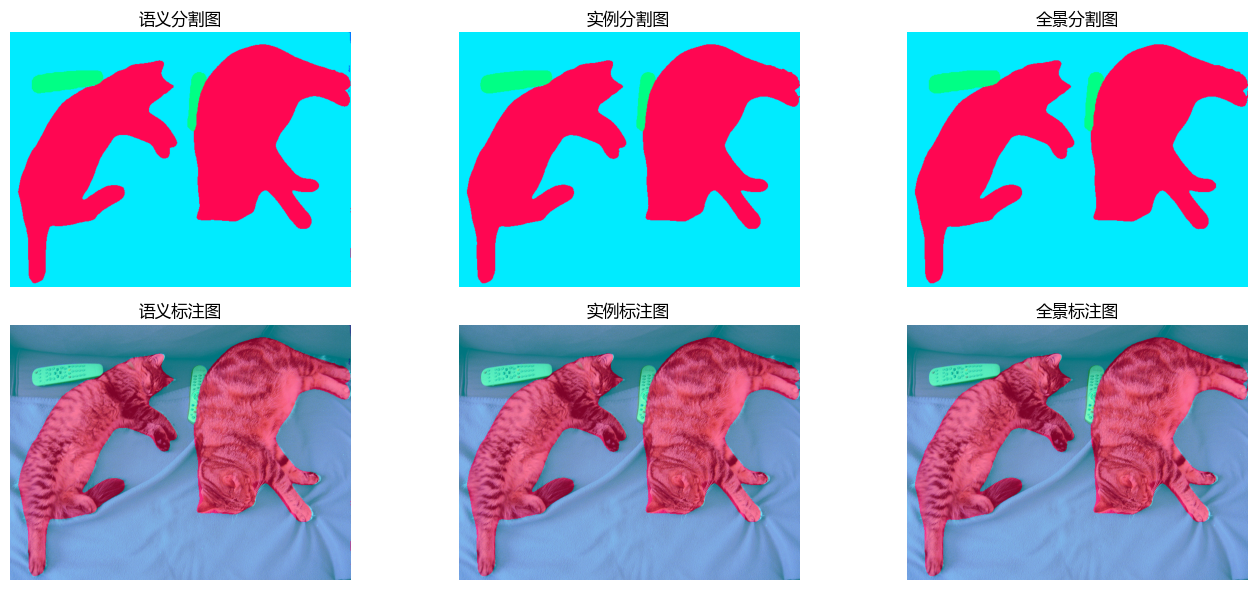

In [28]:
def visual_seg(outputs):
    # 定义20个颜色模版（目标分割的类型在配置文件知道是19种类别）
    palette = np.array(
        [[120, 120, 120], [180, 120, 120], [6, 230, 230], [80, 50, 50],
        [4, 200, 3], [120, 120, 80], [140, 140, 140], [204, 5, 255],
        [230, 230, 230], [4, 250, 7], [224, 5, 255], [235, 255, 7],
        [150, 5, 61], [120, 120, 70], [8, 255, 51], [255, 6, 82],
        [143, 255, 140], [204, 255, 4], [255, 51, 7], [204, 70, 3],
        [0, 102, 200], [61, 230, 250], [255, 6, 51], [11, 102, 255],
        [255, 7, 71], [255, 9, 224], [9, 7, 230], [220, 220, 220],
        [255, 9, 92], [112, 9, 255], [8, 255, 214], [7, 255, 224],
        [255, 184, 6], [10, 255, 71], [255, 41, 10], [7, 255, 255],
        [224, 255, 8], [102, 8, 255], [255, 61, 6], [255, 194, 7],
        [255, 122, 8], [0, 255, 20], [255, 8, 41], [255, 5, 153],
        [6, 51, 255], [235, 12, 255], [160, 150, 20], [0, 163, 255],
        [140, 140, 140], [250, 10, 15], [20, 255, 0], [31, 255, 0],
        [255, 31, 0], [255, 224, 0], [153, 255, 0], [0, 0, 255],
        [255, 71, 0], [0, 235, 255], [0, 173, 255], [31, 0, 255],
        [11, 200, 200], [255, 82, 0], [0, 255, 245], [0, 61, 255],
        [0, 255, 112], [0, 255, 133], [255, 0, 0], [255, 163, 0],
        [255, 102, 0], [194, 255, 0], [0, 143, 255], [51, 255, 0],
        [0, 82, 255], [0, 255, 41], [0, 255, 173], [10, 0, 255],
        [173, 255, 0], [0, 255, 153], [255, 92, 0], [255, 0, 255],
        [255, 0, 245], [255, 0, 102], [255, 173, 0], [255, 0, 20],
        [255, 184, 184], [0, 31, 255], [0, 255, 61], [0, 71, 255],
        [255, 0, 204], [0, 255, 194], [0, 255, 82], [0, 10, 255],
        [0, 112, 255], [51, 0, 255], [0, 194, 255], [0, 122, 255],
        [0, 255, 163], [255, 153, 0], [0, 255, 10], [255, 112, 0],
        [143, 255, 0], [82, 0, 255], [163, 255, 0], [255, 235, 0],
        [8, 184, 170], [133, 0, 255], [0, 255, 92], [184, 0, 255],
        [255, 0, 31], [0, 184, 255], [0, 214, 255], [255, 0, 112],
        [92, 255, 0], [0, 224, 255], [112, 224, 255], [70, 184, 160],
        [163, 0, 255], [153, 0, 255], [71, 255, 0], [255, 0, 163],
        [255, 204, 0], [255, 0, 143], [0, 255, 235], [133, 255, 0],
        [255, 0, 235], [245, 0, 255], [255, 0, 122], [255, 245, 0],
        [10, 190, 212], [214, 255, 0], [0, 204, 255], [20, 0, 255],
        [255, 255, 0], [0, 153, 255], [0, 41, 255], [0, 255, 204],
        [41, 0, 255], [41, 255, 0], [173, 0, 255], [0, 245, 255],
        [71, 0, 255], [122, 0, 255], [0, 255, 184], [0, 92, 255],
        [184, 255, 0], [0, 133, 255], [255, 214, 0], [25, 194, 194],
        [102, 255, 0], [92, 0, 255]]
    )
    w, h = outputs[0]["mask"].size
    img_mask = np.zeros((h, w, 3), dtype=np.uint8)
    for a_obj in outputs:
        score = a_obj["score"]
        label = a_obj["label"]
        mask  = a_obj["mask"]
        label_id = pipe.model.config.label2id[label] 
        mask  = np.array(mask)  # 转换为numpy数组进行运算操作
        img_mask[mask==255, :] = palette[label_id]  # 把图像中mask为255对应的位置替换成模版中对应类别的颜色。
    return img_mask

img_semantic = visual_seg(seg_semantic)
img_instance = visual_seg(seg_instance)
img_panoptic = visual_seg(seg_panoptic)

img = np.array(image)

fuse_semantic = (img * 0.5 + img_semantic * 0.5).astype(np.uint8)
fuse_instance = (img * 0.5 + img_instance * 0.5).astype(np.uint8)
fuse_panoptic = (img * 0.5 + img_panoptic * 0.5).astype(np.uint8)

rows = 2
cols = 3

images = [img_semantic, img_instance, img_panoptic, fuse_semantic, fuse_instance, fuse_panoptic]
titles = ["语义分割图", "实例分割图", "全景分割图", "语义标注图", "实例标注图", "全景标注图"]
plt.figure(figsize=(rows * 7, cols * 2))
for r in range(rows):
    for c in range(cols):
        plt.subplot(rows, cols, cols * r + c + 1)
        plt.imshow(images[cols * r + c])
        plt.axis("off")
        plt.title(titles[cols * r + c])
plt.tight_layout()
plt.show()

- 代码说明：
    - 从配置文件可知，oneformer_coco_swin_large模型分割的目标有134种类别，所以颜色模版中颜色数量我们增加了一些。
    - 我们是直接使用Pipeline的输出，其中每个分隔的目标输出的mask为PIL.Image，这样有一定的好处，也可以直接使用`post_process_panoptic_segmentation`函数的处理结果，所有分割目标返回一个mask（可以利用matplotlib的cmap特性直接可视化）。这两种方式根据情况自己选择。

----